In [40]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
torch.manual_seed(43)

In [41]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
from data_proccessing import labels
class _DenseLayer(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(_DenseLayer, self).__init__()
        self.norm1 = nn.BatchNorm2d(in_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, growth_rate*4, kernel_size=1, stride=1, bias=False)
        self.norm2 = nn.BatchNorm2d(growth_rate*4)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(growth_rate*4, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)
        self.classifier = nn.Linear(growth_rate, len(labels))

    def forward(self, x):
        out = self.conv1(self.relu1(self.norm1(x)))
        out = self.conv2(self.relu2(self.norm2(out)))
        out = torch.cat([x, out], 1)
        return out

In [43]:
class _DenseBlock(nn.Module):
    def __init__(self, num_layers, in_channels, growth_rate):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleList([_DenseLayer(in_channels + i * growth_rate, growth_rate) for i in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [44]:
class _Transition(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(_Transition, self).__init__()
        self.norm = nn.BatchNorm2d(in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.pool(self.conv(self.relu(self.norm(x))))
        return out

In [45]:
import torch.nn.functional as F
from data_proccessing import image_size, labels

# dense = models.densenet121()
class DenseNet(nn.Module):
    def __init__(self):
        super(DenseNet, self).__init__()
        self.conv0 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False).to(torch.float32)
        self.norm0 = nn.BatchNorm2d(64)
        self.relu0 = nn.ReLU(inplace=True)
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.denseblock1 = _DenseBlock(num_layers=3, in_channels=64, growth_rate=4)  # Reduced growth rate
        self.transition1 = _Transition(in_channels=76, out_channels=128)
        self.denseblock2 = _DenseBlock(num_layers=3, in_channels=128, growth_rate=4)  # Added second dense block
        self.norm5 = nn.BatchNorm2d(140, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  # Adjusted to the output size of the last dense block
        self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(in_features=(140), out_features=15, bias=True)  # Adjusted input features

    def forward(self, x):
        x = self.conv0(x)
        x = self.norm0(x)
        x = self.relu0(x)
        out = self.pool0(x)
        out = self.denseblock1(out)
        out = self.transition1(out)
        out = self.denseblock2(out)
        out = F.relu(self.norm5(out))
        out = self.pool1(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        out = F.sigmoid(out)
        return out
    

    
model = DenseNet()
print(model)

DenseNet(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (layers): ModuleList(
      (0): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (classifier): Linear(in_features=4, out_features=15, bias=True)
      )
      (1): _DenseLayer(
        (norm1): BatchNorm2d(68, eps=1e-05, momentum=0.1, affine=True, t

In [46]:
# def train(model, train_loader, optimizer, criterion, device):
#     model.train()
#     epoch_train_loss = 0.0
#     i=0
    
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)
#         optimizer.zero_grad()
#         outputs = model(images)
#         # print(outputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         epoch_train_loss += loss.item()

            
#     return (epoch_train_loss / len(train_loader))

# def evaluate(model, valid_loader, criterion, device):
#     model.eval()
#     valid_loss = 0

#     with torch.no_grad():
#         for images, labels in valid_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)

#             loss = criterion(outputs, labels)
#             valid_loss += loss.item()
    
#     valid_loss /= len(valid_loader)

#     return valid_loss

In [47]:
from helper import train, evaluate
from data_proccessing import train_loader, valid_loader
import os

save_dir = "models/densnet_variation_latest/"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
criterion = nn.BCELoss()
num_epochs = 15
learning_rates = [0.001, 0.0005]
model.to(device)

# Track losses for visualization
train_losses_dict = {}
valid_losses_dict = {}

# Iterate over different learning rates
for lr in learning_rates:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_valid_loss = float('inf')
    train_losses = []  
    valid_losses = []  
    
    for epoch in range(num_epochs):

        avg_train_loss = train(model, train_loader, optimizer, criterion, device)
        train_losses.append(avg_train_loss)
        
        valid_loss = evaluate(model, valid_loader, criterion, device)
        valid_losses.append(valid_loss)
        
        # Print validation loss
        print(f'Learning Rate: {lr}, Epoch: {epoch+1}, Test Loss: {avg_train_loss:.4f}, Validation Loss: {valid_loss:.4f}')
        
        # Save the best model if validation loss improves
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), os.path.join(save_dir, f'best_model_lr_{lr}.pt'))

    # Store losses for visualization
    train_losses_dict[lr] = train_losses
    valid_losses_dict[lr] = valid_losses

# Save losses dictionaries for visualization later
torch.save(train_losses_dict, os.path.join(save_dir, 'train_losses.pt'))
torch.save(valid_losses_dict, os.path.join(save_dir, 'valid_losses.pt'))

Learning Rate: 0.001, Epoch: 1, Test Loss: 0.3874, Validation Loss: 0.3619
Learning Rate: 0.001, Epoch: 2, Test Loss: 0.3669, Validation Loss: 0.3652
Learning Rate: 0.001, Epoch: 3, Test Loss: 0.3662, Validation Loss: 0.3631
Learning Rate: 0.001, Epoch: 4, Test Loss: 0.3650, Validation Loss: 0.3792
Learning Rate: 0.001, Epoch: 5, Test Loss: 0.3639, Validation Loss: 0.3886
Learning Rate: 0.001, Epoch: 6, Test Loss: 0.3638, Validation Loss: 0.4153
Learning Rate: 0.001, Epoch: 7, Test Loss: 0.3625, Validation Loss: 0.4217
Learning Rate: 0.001, Epoch: 8, Test Loss: 0.3619, Validation Loss: 0.4394
Learning Rate: 0.001, Epoch: 9, Test Loss: 0.3610, Validation Loss: 0.3680
Learning Rate: 0.001, Epoch: 10, Test Loss: 0.3606, Validation Loss: 0.3917
Learning Rate: 0.001, Epoch: 11, Test Loss: 0.3602, Validation Loss: 0.3566
Learning Rate: 0.001, Epoch: 12, Test Loss: 0.3598, Validation Loss: 0.3774
Learning Rate: 0.001, Epoch: 13, Test Loss: 0.3595, Validation Loss: 0.3772
Learning Rate: 0.001,

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


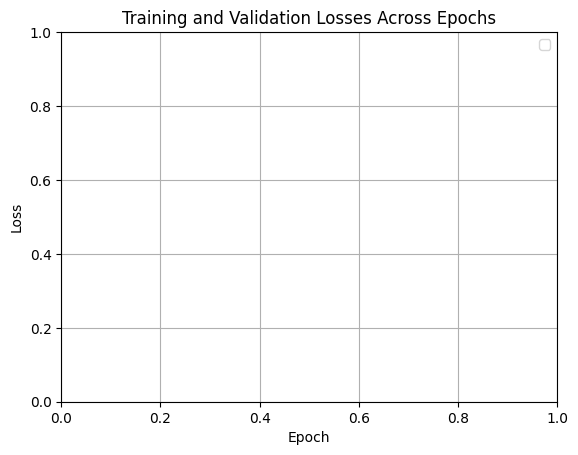

In [48]:
# import matplotlib.pyplot as plt
# # Add labels and title
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training and Validation Losses Across Epochs')
# plt.legend()
# plt.grid(True)

# # Save or show the plot
# plt.savefig(os.path.join(save_dir, 'loss_plot.png'))  # Save the plot as an image file
# plt.show() 

In [49]:
from data_proccessing import test_loader
from helper import test
import pandas as pd

save_dir = "models/densnet_variation_latest/"
# Define Params
criterion = nn.BCELoss()
num_epochs = 15
model.to(device)

learning_rates = [0.001, 0.0005]
for lr in learning_rates:
    model_path = os.path.join(save_dir, f'best_model_lr_{lr}.pt')  # Change the filename accordingly
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    metrics, loss = test(model, test_loader, criterion, device)


    print(metrics, loss)

    Precision  Accuracy  Recall  F1-score
0         0.0  0.811512     0.0         0
1         0.0  0.883747     0.0         0
2         0.0  0.878104     0.0         0
3         0.0  0.891648     0.0         0
4         0.0  0.762980     0.0         0
5         0.0  0.917607     0.0         0
6         0.0  0.898420     0.0         0
7         0.0  0.946953     0.0         0
8         0.0  0.713318     0.0         0
9         0.0  0.889391     0.0         0
10        0.0  0.932280     0.0         0
11        0.0  0.881490     0.0         0
12        0.0  0.879233     0.0         0
13        0.0  0.896163     0.0         0 0.36477512387292726
    Precision  Accuracy  Recall  F1-score
0           0  0.811512     0.0         0
1           0  0.883747     0.0         0
2           0  0.878104     0.0         0
3           0  0.892777     0.0         0
4           0  0.762980     0.0         0
5           0  0.917607     0.0         0
6           0  0.898420     0.0         0
7           0 

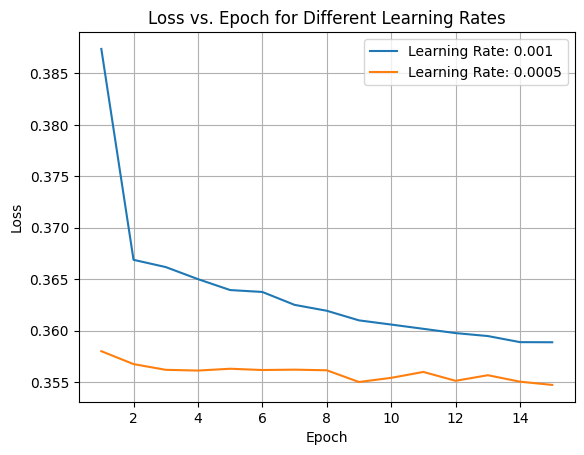

In [50]:
from helper import visualise_loss

save_dir = "models/densnet_variation_latest/"
model_path = os.path.join(save_dir, f'train_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)

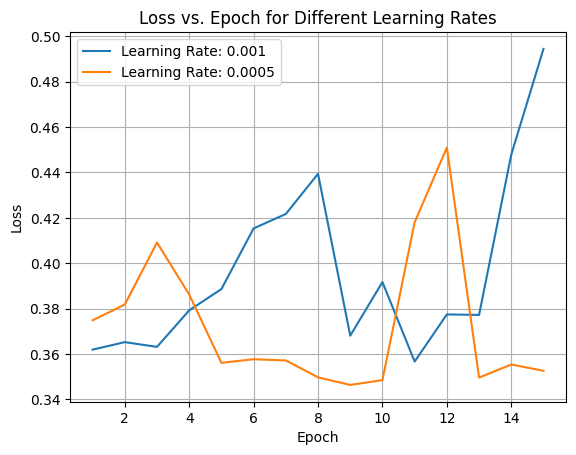

In [51]:
save_dir = "models/densnet_variation_latest/"
model_path = os.path.join(save_dir, f'valid_losses.pt')  # Change the filename accordingly
visualise_loss(model_path)